In [1]:
!pip install pandas numpy scikit-learn xgboost tqdm numpy_financial fredapi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from tqdm import tqdm


In [3]:
pd.set_option('display.max_columns', None) # 모든 열 다 보기
pd.set_option('display.max_rows', None) # 모든 행 다 보기
pd.set_option('display.width', None) # 열 너비 넉넉하게
pd.set_option('display.max_colwidth', None) # 열 안의 값 자르지 않게
tqdm.pandas()

# AWS S3에서 데이터 load
url = "https://snu-bigdata-fintech-ai.s3.ap-northeast-2.amazonaws.com/data/interim/preprocessed_data_ver.3.0.csv"
df = pd.read_csv(url)
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,mths_since_recent_inq_missing,installment_missing,inq_last_6mths_missing,mths_since_last_delinq_missing,total_acc_missing,recoveries_missing,open_acc_missing,all_util_missing,last_fico_range_high_missing,open_act_il_missing,total_bal_il_missing,revol_bal_missing,open_il_24m_missing,acc_now_delinq_missing,annual_inc_missing,pub_rec_missing,fico_range_low_missing,max_bal_bc_missing,delinq_2yrs_missing,open_rv_12m_missing,open_acc_6m_missing,delinq_amnt_missing,open_rv_24m_missing,mths_since_recent_revol_delinq_missing,fico_range_high_missing,funded_amnt_missing,inq_last_12m_missing,collection_recovery_fee_missing,mths_since_rcnt_il_missing,open_il_12m_missing,il_util_missing,risk_free_rate,cash_flow,irr
0,6000.0,36,187.94,2.0,10.714440,2017-12-01,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0196,"[-6000.0, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94, 187.94]",0.082696
1,23200.0,60,680.82,10.0,11.608245,2016-07-01,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,

In [4]:
# 독립변수에서 제외할 변수 목록
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default', 'issue_d',
    'risk_free_rate', 'cash_flow', 'irr'
]

X = df.drop(columns=drop_cols)
y = df['default']

In [2]:
# Sharpe 계산 함수
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)

In [6]:
# 하이퍼파라미터 범위 지정
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# 튜닝용 고정된 데이터셋으로 하이퍼파라미터 탐색 1회 수행
X_tune, _, y_tune, _ = train_test_split(X, y, test_size=0.3, stratify=y)

model_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
search = RandomizedSearchCV(
    model_base, param_distributions=param_dist, n_iter=9,
    scoring='roc_auc', cv=2, n_jobs=1
)
search.fit(X_tune, y_tune)

best_params = search.best_params_
print("✅ Best hyperparameters (from tuning):", best_params)

c:\Users\seon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\seon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\seon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:16:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\seon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:17:04] WARNING: C:\actions-r

✅ Best hyperparameters (from tuning): {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.8}


In [7]:
# 결과 저장용 리스트
best_models = []
best_thresholds = []
validation_sharpes = []
test_sharpes = []
test_approval_rates = []
test_irr_means = []
test_irr_positive_rates = []

# 해당 best 파라미터를 기반으로 100번 반복 학습 및 평가
for i in tqdm(range(100)):
    # Train-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=i, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=i, stratify=y_temp
    )

    # best 하이퍼파라미터로 모델 생성 및 학습
    model = XGBClassifier(**best_params, eval_metric='logloss')
    model.fit(X_train, y_train)

    # 검증 세트 예측 및 threshold 탐색
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.0, 0.05)

    best_sharpe = -np.inf
    best_threshold = None
    val_indices = X_val.index
    df_val = df.loc[val_indices]

    for threshold in thresholds:
        approved_mask = y_pred_proba <= threshold
        denied_mask = ~approved_mask

        selected = df_val.copy()
        selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
        selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

        returns = selected['irr_adj']
        risk_free = selected['risk_free_rate']
        valid = returns.notnull() & risk_free.notnull()

        if valid.sum() < 2:
            continue

        sharpe = calculate_sharpe(returns[valid], risk_free[valid])

        if sharpe > best_sharpe:
            best_sharpe = sharpe
            best_threshold = threshold

    best_models.append(model)
    best_thresholds.append(best_threshold)
    validation_sharpes.append(best_sharpe)

    # Test 데이터 평가
    y_test_proba = model.predict_proba(X_test)[:, 1]
    test_approved_mask = y_test_proba <= best_threshold
    df_test = df.loc[X_test.index]
    test_selected = df_test[test_approved_mask]

    returns_test = test_selected['irr']
    risk_free_test = test_selected['risk_free_rate']
    valid = returns_test.notnull() & risk_free_test.notnull()

    returns_test = returns_test[valid]
    risk_free_test = risk_free_test[valid]

    sharpe_test = calculate_sharpe(returns_test, risk_free_test)
    test_sharpes.append(sharpe_test)
    test_approval_rates.append(len(returns_test) / len(df_test))
    test_irr_means.append(returns_test.mean())
    test_irr_positive_rates.append((returns_test > 0).mean())

# 최종 결과 출력
best_idx = np.argmax(test_sharpes)
print("✅ Best model index:", best_idx)
print("✅ Best validation Sharpe ratio:", validation_sharpes[best_idx])
print("✅ Best test Sharpe ratio:", test_sharpes[best_idx])
print("✅ Best approval rate:", test_approval_rates[best_idx])
print("✅ Mean IRR:", test_irr_means[best_idx])
print("✅ Positive IRR ratio:", test_irr_positive_rates[best_idx])
print("✅ Best threshold:", best_thresholds[best_idx])
print("✅ Best model params:", best_models[best_idx].get_params())


100%|██████████| 100/100 [2:06:07<00:00, 75.68s/it] 

✅ Best model index: 5
✅ Best validation Sharpe ratio: 0.6978644215225133
✅ Best test Sharpe ratio: 1.141677394108188
✅ Best approval rate: 0.5967916786123854
✅ Mean IRR: 0.12135117722673275
✅ Positive IRR ratio: 0.9905271612259144
✅ Best threshold: 0.05
✅ Best model params: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': 5, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'rando

In [8]:
print("Best thresholds from 2 runs:")
print(best_thresholds)

print("\nValidation Sharpe Ratios from 2 runs:")
print(validation_sharpes)

print("\nTest Sharpe Ratios from 2 runs:")
print(test_sharpes)

print("\nTest Approval Rates:")
print(test_approval_rates)

print("\nTest IRR Means:")
print(test_irr_means)

print("\nTest IRR Positive Rates:")
print(test_irr_positive_rates)

Best thresholds from 2 runs:
[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

Validation Sharpe Ratios from 2 runs:
[0.6864842868565458, 0.6954189816456358, 0.7004856024674121, 0.6896216999492021, 0.7034381785844365, 0.6978644215225133, 0.6992761486665935, 0.6931610490425258, 0.6958661818366195, 0.688545776451044, 0.6984079243131847, 0.6944622896001362, 0.6993686842015984, 0.6936546477061517, 0.686109489336628, 0.6965328801225177, 0.6864547940

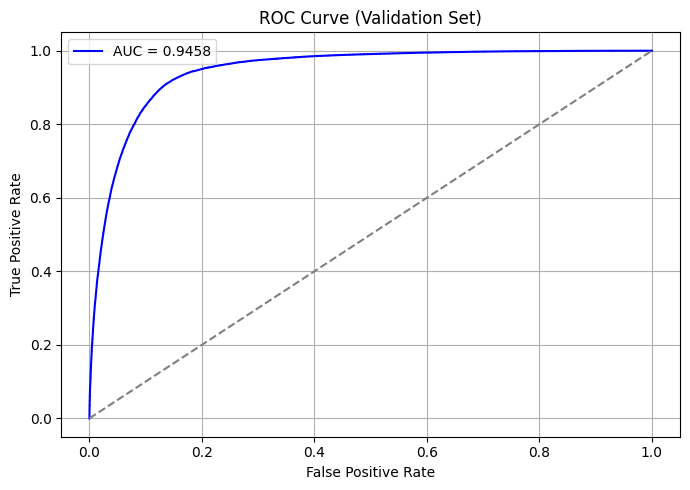

In [15]:
# 최적 모델
best_model = best_models[best_idx]

# 검증 데이터에서 예측 확률
y_val_proba = best_model.predict_proba(X_val)[:, 1]

# --------------------------
# 1. ROC Curve 시각화
# --------------------------
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (Validation Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



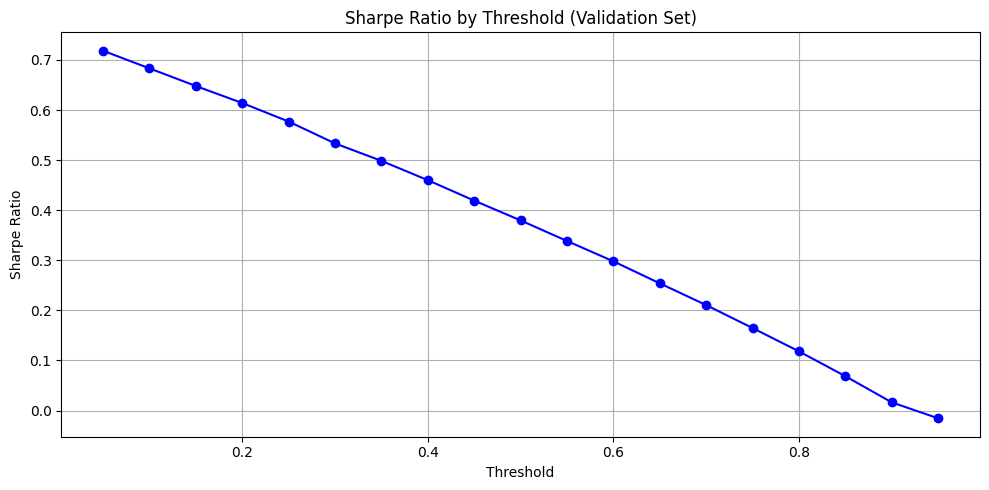

In [18]:
# --------------------------
# 2. Threshold별 Sharpe Ratio
# --------------------------
thresholds = np.arange(0.0, 1.0, 0.05)
sharpe_ratios = []

for threshold in thresholds:
    approved_mask = y_val_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']
    valid = returns.notnull() & risk_free.notnull()

    if valid.sum() < 2:
        sharpe_ratios.append(np.nan)
    else:
        sharpe = calculate_sharpe(returns[valid], risk_free[valid])
        sharpe_ratios.append(sharpe)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, sharpe_ratios, marker='o', color='blue')
plt.title("Sharpe Ratio by Threshold (Validation Set)")
plt.xlabel("Threshold")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

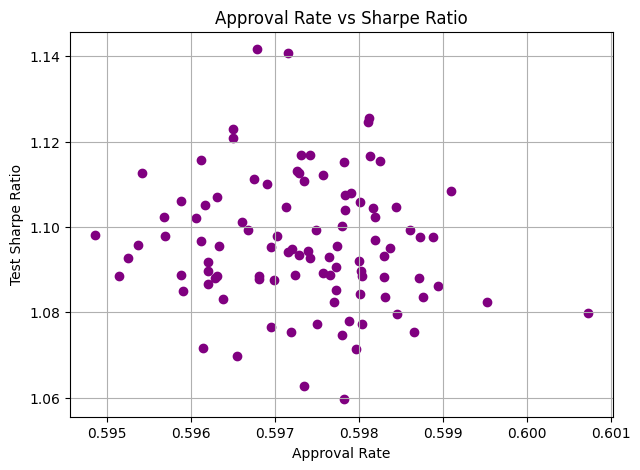

In [14]:
# 🔍 IRR 평균 및 Positive 비율 비교
plt.figure(figsize=(7, 5))
plt.scatter(test_approval_rates, test_sharpes, color='purple')
plt.title("Approval Rate vs Sharpe Ratio")
plt.xlabel("Approval Rate")
plt.ylabel("Test Sharpe Ratio")
plt.grid(True)
plt.show()

In [37]:
!pip install joblib

In [ ]:
import joblib

# 저장
joblib.dump(best_models[best_idx], 'model_xgb.pkl')

# 불러오기
# from joblib import load
# loaded_model = load('best_model.pkl')


['model_xgb.pkl']

In [3]:
from joblib import load

df = pd.read_csv('https://snu-bigdata-fintech-ai.s3.ap-northeast-2.amazonaws.com/data/test/preprocessing_lending_club_2020_test.csv')

# 최적 모델과 threshold
best_model = load('model_xgb.pkl')
best_threshold = 0.05

X_test = df[best_model.get_booster().feature_names].copy()

# Test 데이터 준비
y_test_proba = best_model.predict_proba(X_test)[:, 1]  # 양성 클래스 확률
approved_mask = y_test_proba <= best_threshold         # threshold 기준 승인 여부
df_test_selected = df.loc[X_test.index].copy()         # 테스트 샘플 원본

# 승인된 대출에는 irr, 거부된 대출은 risk_free_rate 적용
df_test_selected['irr_adj'] = df_test_selected['risk_free_rate']  # 기본값 설정
df_test_selected.loc[approved_mask, 'irr_adj'] = df_test_selected.loc[approved_mask, 'irr']

# Sharpe ratio 계산
returns = df_test_selected['irr_adj']
risk_free = df_test_selected['risk_free_rate']
valid = returns.notnull() & risk_free.notnull()

sharpe_final = calculate_sharpe(returns[valid], risk_free[valid])
approval_rate_final = approved_mask.sum() / len(approved_mask)
mean_irr = returns[valid].mean()
positive_rate = (returns[valid] > 0).mean()

# 결과 출력
print("🎯 Final Test Prediction Summary")
print("✅ Sharpe Ratio:", sharpe_final)
print("✅ Approval Rate:", approval_rate_final)
print("✅ Mean IRR:", mean_irr)
print("✅ Positive IRR Ratio:", positive_rate)

# 필요시 승인된 대출 정보 출력
approved_loans = df_test_selected[approved_mask]

🎯 Final Test Prediction Summary
✅ Sharpe Ratio: 0.6839290127571412
✅ Approval Rate: 0.6028380033520994
✅ Mean IRR: 0.07717735084212468
✅ Positive IRR Ratio: 0.993434129098801


📌 Confusion Matrix 결과
🔵 True Negatives (TN): 443293
🔴 False Positives (FP): 155968
🟡 False Negatives (FN): 5585
🟢 True Positives (TP): 139762


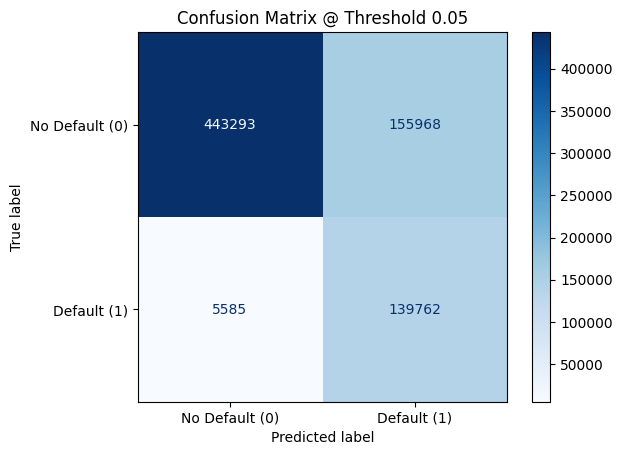

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 실제 라벨 (0 또는 1)이 있다고 가정하고
# df에는 'default' 컬럼이 실제값으로 존재해야 함
y_true = df['default']   # 실제 부도 여부
y_pred = (y_test_proba > best_threshold).astype(int)  # 예측 (1이면 거절, 0이면 승인)

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# 출력
print("📌 Confusion Matrix 결과")
print(f"🔵 True Negatives (TN): {tn}")
print(f"🔴 False Positives (FP): {fp}")
print(f"🟡 False Negatives (FN): {fn}")
print(f"🟢 True Positives (TP): {tp}")

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default (0)", "Default (1)"])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix @ Threshold {best_threshold}")
plt.show()

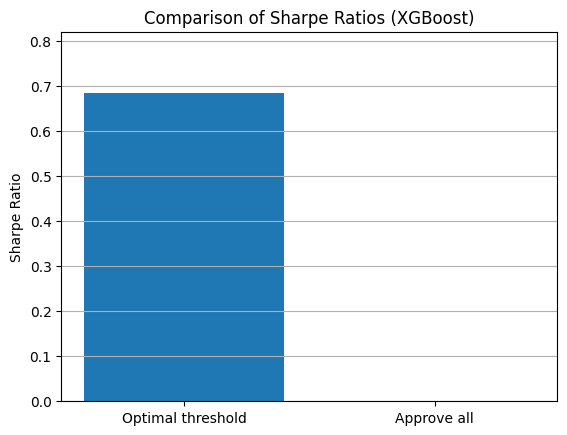

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sharpe ratio calculation
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)
# Prediction probabilities
y_test_proba = best_model.predict_proba(X_test)[:, 1]
# Case 1: Optimal threshold
threshold_opt = 0.05
approved_opt = y_test_proba <= threshold_opt
returns_opt = df_test_selected.loc[approved_opt, 'irr']
denied_opt = ~approved_opt
returns_opt = pd.concat([
    returns_opt,
    df_test_selected.loc[denied_opt, 'risk_free_rate']
])

# Case 2: Approve all
approved_all = np.ones_like(y_test_proba, dtype=bool)
returns_all = df_test_selected['irr']
# Risk-free rate
risk_free = df_test_selected['risk_free_rate']
# Remove NaNs
valid_opt = returns_opt.notnull() & risk_free.notnull()
valid_all = returns_all.notnull() & risk_free.notnull()
# Calculate Sharpe ratios
sharpe_opt = calculate_sharpe(returns_opt[valid_opt], risk_free[valid_opt])
sharpe_all = calculate_sharpe(returns_all[valid_all], risk_free[valid_all])
# Plot
plt.bar(['Optimal threshold', 'Approve all'], [sharpe_opt, sharpe_all])
plt.ylabel("Sharpe Ratio")
plt.title("Comparison of Sharpe Ratios (XGBoost)")
plt.ylim(0, max(sharpe_opt, sharpe_all) * 1.2)
plt.grid(axis='y')
plt.show()